Tengo unas apps (SizeMe AI y Simple Size) para las cuales estimo el talle que deben comprar los usuarios por medio de ecommerce. El metodo para hacerlo es **comparar las medidas del usuario con la tabla de talles** del proveedor.

Para saber las medidas del usuario hay 3 metodos:
   - El Input directo del usuario.
   - El usuario pone su peso, edad, altura y genero. A partir de ello estimamos las medidas relevantes.
   - El usuario se saca dos fotos (una de frente una de perfil) [Tecnicamente sacamos 3 y 3, tomamos la mediana de cada medida, y hay algun otro algoritmo extra. Si hace falta se puede explicar mas en detalle].

Las medidas corporales que usamos son:
   - Circunferencia del pecho
   - Circunferencia de hombros
   - Circunferencia de cintura
   - Circunferencia de cadera
   - Circunferencia de gluteos
   - Otras que no estan disponibles en este dataset

El objetivo de este notebook es:
   - Confirmar la relación y la capacidad predictiva entre las variables input (peso, altura, genero, edad) y output (medidas corporales).

Por cuestiones de tiempo voy a hacer la validación solo con varones. De todas maneras los mismos analisis debieran hacerse para mujeres asi que a fines de evaluacion asumo debiera servirles.

El dataset: [https://www.kaggle.com/datasets/mexwell/body-measurements/data](https://www.kaggle.com/datasets/mexwell/body-measurements/data)

In [ ]:
import kagglehub
import pandas as pd
import numpy as np
import statistics as st
import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error

path = kagglehub.dataset_download("mexwell/body-measurements")
path = f'{path}/{os.listdir(path)[0]}'
print(path)

/kaggle/input/body-measurements/bdims.csv


Hacemos el Dataset mas legible, eliminamos variables innecesarias y modificamos las variables que notamos inconsistentes. Luego de todo esto creamos dos dataframes separados para varon y mujer, con el fin de facilitarnos el trabajo a futuro.

Acá dejo que significan los prefijos de las variables.
  - a: **Ancho**. Se mide de lado a lado a lado.
  - p: **Profundidad**. Se mide de lado a lado con la persona de perfil.
  - c: **Circunferencia**. Se mide el contorno corporal.

In [ ]:
df = pd.read_csv(path)

df.columns = [
    'a_hombros',
    'a_pelvis',
    'a_cadera',
    'a_pecho',
    'p_pecho',
    'a_codo',  # Es la suma.... Dividir por 2
    'a_muneca',  # Es la suma.... Dividir por 2
    'a_rodilla',  # Es la suma.... Dividir por 2
    'a_tobillo',  # Es la suma.... Dividir por 2
    'c_hombros',
    'c_pecho',
    'c_cintura',
    'c_abdominales',
    'c_cadera',
    'c_gluteos',
    'c_biceps',
    'c_antebrazo',
    'c_rodilla', # Es la suma.... Dividir por 2
    'c_pierna',
    'c_tobillo',
    'c_muneca',
    'edad',
    'peso',
    'altura',
    'genero'  # 0 varon, 1 mujer
    ]

# Pasemos los que suman dos partes del cuerpo para que sea una (en vez de dos codos, quiero saber el ancho siempre de 1). No se van a usar, pero si en un futuro las queremos agregar lo tenemos acá.
columnas_sum = [
    'a_codo',
    'a_muneca',
    'a_rodilla',
    'a_tobillo',
    'c_biceps',
    'c_antebrazo',
    'c_rodilla',
    'c_tobillo',
    'c_muneca',
]

for col in columnas_sum:
    df[col] = df[col] / 2

# Borramos medidas que no nos interesan trabajar
columnas_a_borrar = [
    'p_pecho',
    'a_codo',
    'a_muneca',
    'a_rodilla',
    'a_tobillo',
    'c_rodilla',
    'c_muneca',
    'c_abdominales',
    'c_biceps',
    'c_tobillo',
    'c_antebrazo',
    'c_pierna'
]
df = df.drop(columns=columnas_a_borrar)

# Las diferencias entre Hombres y mujeres a nivel corporal son varias. Dividir el df para a futuro realizar pruebas por separado.

df_mujeres = df[df['genero'] == 0].copy()
df_varones = df[df['genero'] == 1].copy()\

df_varones = df_varones.drop(columns=['genero'])
df_mujeres = df_mujeres.drop(columns=['genero'])

print(df_varones.columns.tolist())

['a_hombros', 'a_pelvis', 'a_cadera', 'a_pecho', 'c_hombros', 'c_pecho', 'c_cintura', 'c_cadera', 'c_gluteos', 'edad', 'peso', 'altura']


In [ ]:
df.describe()

,a_hombros,a_pelvis,a_cadera,a_pecho,c_hombros,c_pecho,c_cintura,c_cadera,c_gluteos,edad,peso,altura,genero
count,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000
mean,38.811440,27.829980,31.980473,19.226036,108.195069,93.333531,76.979487,96.680868,56.855819,30.181460,69.147535,171.143787,0.487179
std,3.059132,2.206308,2.030916,2.515877,10.374834,10.027621,11.012688,6.680623,4.459889,9.608472,13.345762,9.407205,0.500329
min,32.400000,18.700000,24.700000,14.300000,85.900000,72.600000,57.900000,78.800000,46.300000,18.000000,42.000000,147.200000,0.000000
25%,36.200000,26.500000,30.600000,17.300000,99.450000,85.300000,68.000000,92.000000,53.700000,23.000000,58.400000,163.800000,0.000000
50%,38.700000,28.000000,32.000000,19.000000,108.200000,91.600000,75.800000,96.000000,56.300000,27.000000,68.200000,170.300000,0.000000
75%,41.150000,29.250000,33.350000,20.900000,116.550000,101.150000,84.500000,101.000000,59.500000,36.000000,78.850000,177.800000,1.000000
max,47.400000,34.700000,38.000000,27.500000,134.800000,118.700000,113.200000,128.300000,75.700000,67.000000,116.400000,198.100000,1.000000


El proximo bloque van a ser de funciones que podrían reutilizarse.

In [ ]:
def color_por_correlacion(val):
    a = abs(val)
    if a < -0.8 or a > 0.8: return 'red'
    if a < -0.6 or a > 0.6: return 'orange'
    if a < -0.4 or a > 0.4: return 'yellow'
    return 'gray'

def colores_para_correlaciones(cor):
  return [color_por_correlacion(val) for val in cor]


def entrenar_reg_lineal_demo(res, df, medida):
    X = df[['edad', 'peso', 'altura']]
    y = df[medida]

    X = X.dropna()
    y = y.loc[X.index]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    modelo = LinearRegression()
    modelo.fit(X_train, y_train)

    y_pred = modelo.predict(X_test)

    nueva_fila = pd.DataFrame({
        'Medida': [medida],
        'Coeficientes': [list(modelo.coef_.round(2))],
        'Intercepto': [modelo.intercept_.round(2)],
        'R2': [round(r2_score(y_test, y_pred), 2)],
        'mae': mean_absolute_error(y_test, y_pred),
        'rmse': np.sqrt(mean_squared_error(y_test, y_pred))
    })

    res = pd.concat([res, nueva_fila], ignore_index=True)
    return res


Como esta compuesta la muestra en su total.

Agrego percentil 5 y 95 porque me hacen un filtro de que esperar comunmente en los usuarios.

In [ ]:
df[['edad', 'peso', 'altura', 'genero']].describe(percentiles=[.05, .25, .5, .75, .95]).round(2)

,edad,peso,altura,genero
count,507.00,507.00,507.00,507.00
mean,30.18,69.15,171.14,0.49
std,9.61,13.35,9.41,0.50
min,18.00,42.00,147.20,0.00
5%,19.30,49.38,157.00,0.00
25%,23.00,58.40,163.80,0.00
50%,27.00,68.20,170.30,0.00
75%,36.00,78.85,177.80,1.00
95%,48.70,91.40,188.00,1.00
max,67.00,116.40,198.10,1.00


¿Están realmente relacionadas las medidas corporales al género?

/tmp/ipython-input-312-574638747.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


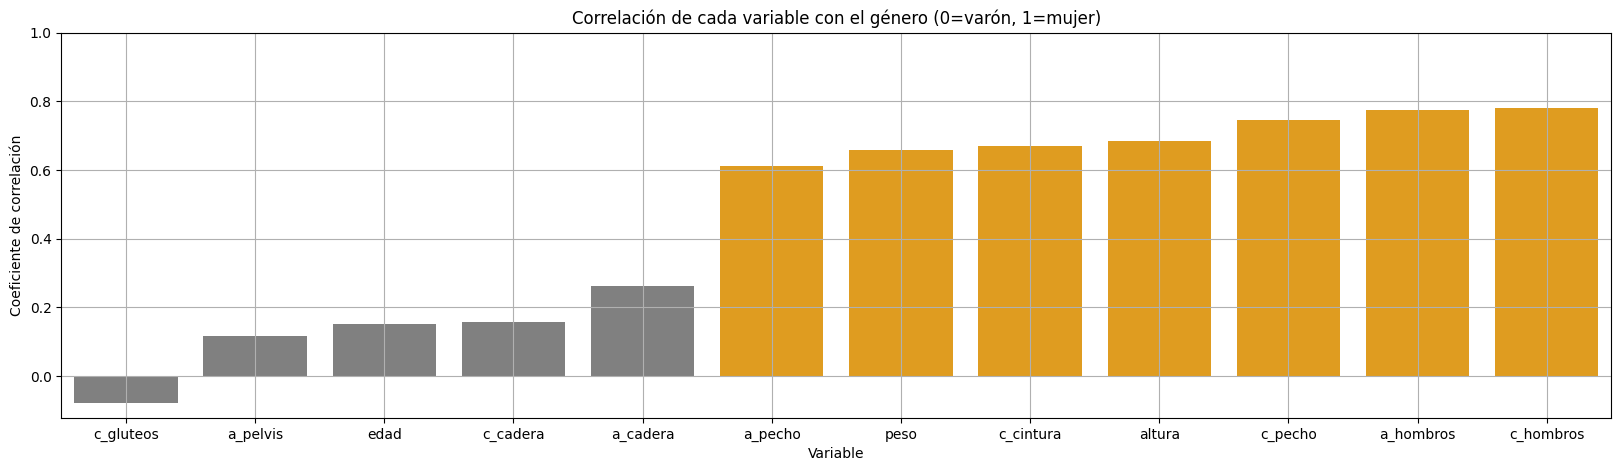

In [ ]:

correlaciones = df.corr(numeric_only=True)['genero'].drop('genero')
correlaciones = correlaciones.sort_values()

plt.figure(figsize=(20, 5))
sns.barplot(
    x=correlaciones.index,
    y=correlaciones.values,
    palette=colores_para_correlaciones(correlaciones)
)
plt.ylim(top=1)
plt.title("Correlación de cada variable con el género (0=varón, 1=mujer)")
plt.ylabel("Coeficiente de correlación")
plt.xlabel("Variable")
plt.grid(True)
plt.show()


¿Como esta compuesta la muestra de hombres?

Agrego percentil 5 y 95 porque me hacen un filtro de que esperar comunmente en los usuarios.

In [ ]:
df_varones[['edad', 'peso', 'altura']].describe(percentiles=[.05, .25, .5, .75, .95]).round(2)

,edad,peso,altura
count,247.00,247.00,247.00
mean,31.67,78.14,177.75
std,10.15,10.51,7.18
min,18.00,53.90,157.20
5%,21.00,61.58,166.58
25%,24.00,70.95,172.90
50%,29.00,77.30,177.80
75%,37.00,85.50,182.65
95%,51.70,94.24,190.50
max,65.00,116.40,198.10


Vamos a filtrar el percentil 1.5 y el 98.5 como para sacar los datos mas atipicos que pueden afectar al 97% de los usuarios.

Como no conozco del todo el dataset es una forma económica de fletar casos atipicos. Las variables que tomamos de punto en este caso son peso y altura.

In [ ]:
altura_p1 = df['altura'].quantile(0.015)
altura_p99 = df['altura'].quantile(0.985)

peso_p1 = df['peso'].quantile(0.015)
peso_p99 = df['peso'].quantile(0.985)

# Filtrar el DataFrame excluyendo los extremos
df = df[
    (df['altura'] > altura_p1) & (df['altura'] < altura_p99) &
    (df['peso'] > peso_p1) & (df['peso'] < peso_p99)
]

¿Esta la edad relacionada a las medidas corporales? ¿A Cuales?

/tmp/ipython-input-315-985519183.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


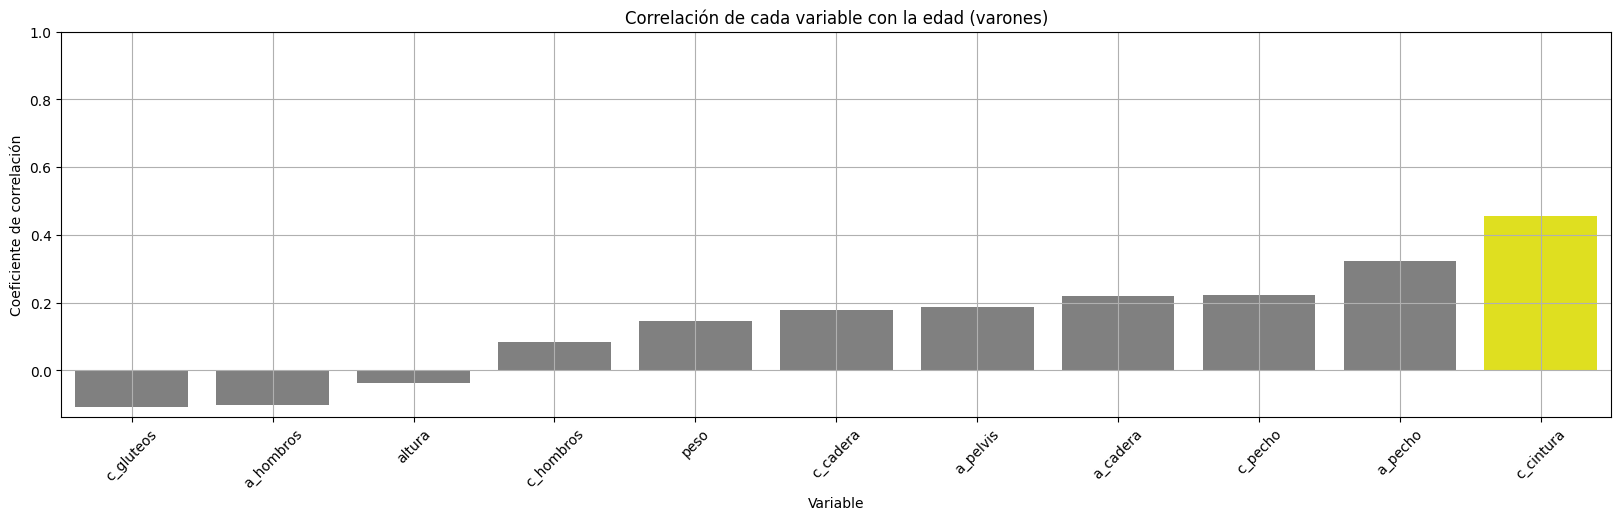

In [ ]:
correlaciones = df_varones.corr(numeric_only=True)['edad'].drop('edad')
correlaciones = correlaciones.sort_values()

plt.figure(figsize=(20, 5))
sns.barplot(
    x=correlaciones.index,
    y=correlaciones.values,
    palette=colores_para_correlaciones(correlaciones)
)
plt.ylim(top=1)
plt.title("Correlación de cada variable con la edad (varones)")
plt.ylabel("Coeficiente de correlación")
plt.xlabel("Variable")
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

¿Esta el peso relacionado a las medidas corporales? ¿A Cuales?

/tmp/ipython-input-319-1561581354.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


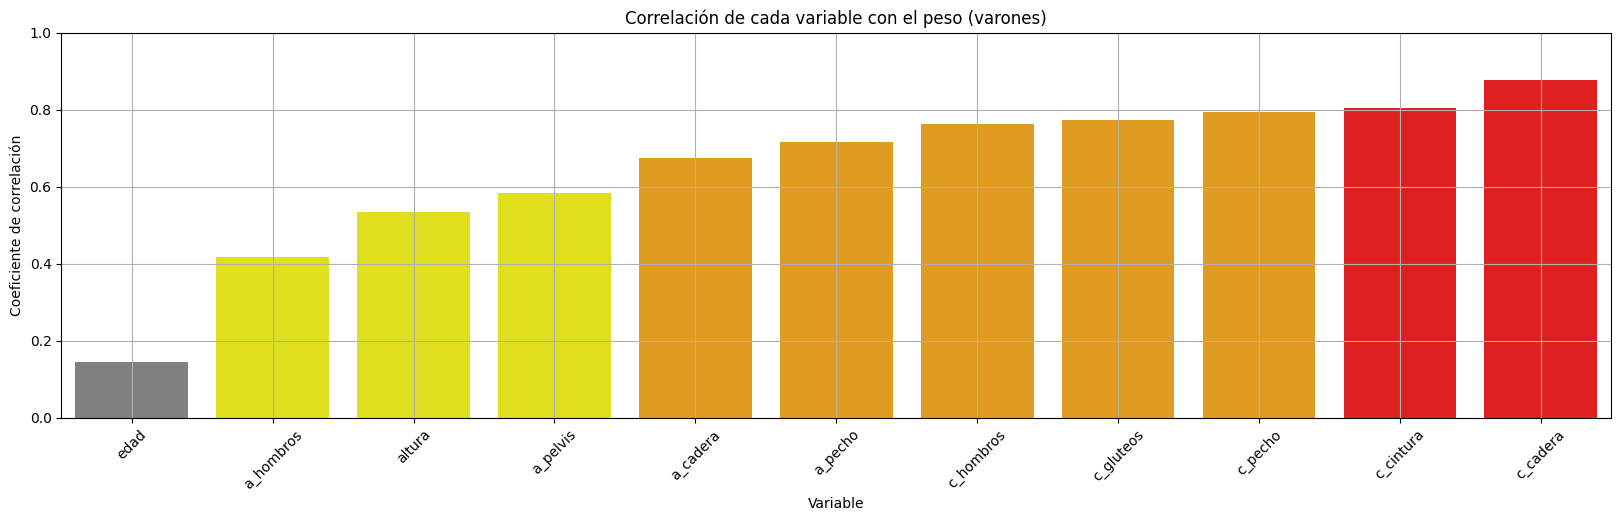

In [319]:
correlaciones = df_varones.corr(numeric_only=True)['peso'].drop('peso')
correlaciones = correlaciones.sort_values()

colores = [color_por_correlacion(val) for val in correlaciones]

plt.figure(figsize=(20, 5))
sns.barplot(
    x=correlaciones.index,
    y=correlaciones.values,
    palette=colores
)
plt.ylim(top=1)
plt.title("Correlación de cada variable con el peso (varones)")
plt.ylabel("Coeficiente de correlación")
plt.xlabel("Variable")
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

¿Esta la altura relacionada a las medidas corporales? ¿A Cuales?

/tmp/ipython-input-320-2941832661.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


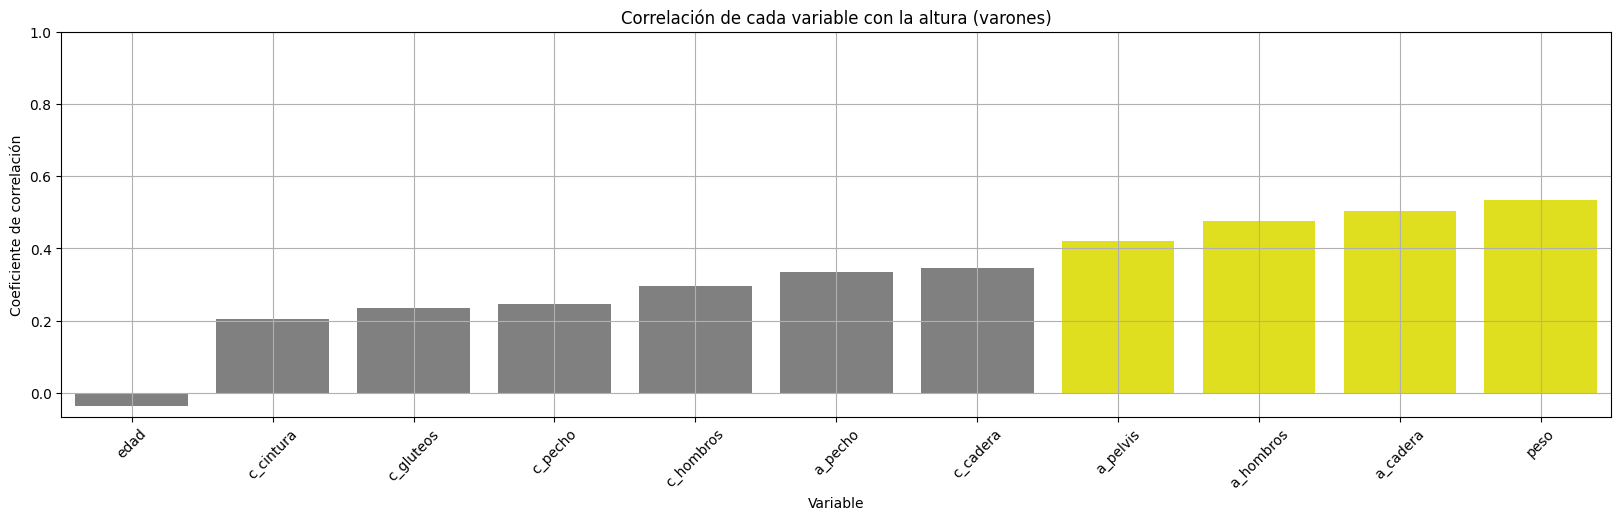

In [320]:
correlaciones = df_varones.corr(numeric_only=True)['altura'].drop('altura')
correlaciones = correlaciones.sort_values()

colores = [color_por_correlacion(val) for val in correlaciones]

plt.figure(figsize=(20, 5))
sns.barplot(
    x=correlaciones.index,
    y=correlaciones.values,
    palette=colores
)
plt.ylim(top=1)
plt.title("Correlación de cada variable con la altura (varones)")
plt.ylabel("Coeficiente de correlación")
plt.xlabel("Variable")
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

Testeamos si con regresion lineal podemos predecir la circunferencia del pecho

In [ ]:
reg_df = pd.DataFrame(columns=['Medida', 'Coeficientes', 'Intercepto', 'R2', 'mae', 'rmse'])

reg_df = entrenar_reg_lineal_demo(reg_df, df, 'c_hombros')
reg_df = entrenar_reg_lineal_demo(reg_df, df, 'c_pecho')
reg_df = entrenar_reg_lineal_demo(reg_df, df, 'c_cintura')
reg_df = entrenar_reg_lineal_demo(reg_df, df, 'c_cadera')
reg_df = entrenar_reg_lineal_demo(reg_df, df, 'c_gluteos')
reg_df

/tmp/ipython-input-310-1803105950.py:37: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  res = pd.concat([res, nueva_fila], ignore_index=True)


,Medida,Coeficientes,Intercepto,R2,mae,rmse
0,c_hombros,"[-0.0, 0.7, 0.03]",55.62,0.68,4.348080,5.495812
1,c_pecho,"[0.08, 0.74, -0.1]",56.89,0.78,3.402247,4.484010
2,c_cintura,"[0.23, 0.86, -0.25]",53.71,0.82,3.207271,4.159308
3,c_cadera,"[0.01, 0.51, -0.31]",114.19,0.61,2.999993,3.897266
4,c_gluteos,"[-0.11, 0.32, -0.29]",87.61,0.44,2.725779,3.338012


Las 3 medidas que mas se usan que son cadera cintura y pecho podemos ver que dan un R2 al menos aceptable y que el margen de error (mae) es efectivamente al menos siempre menor a 4, 5 y 6.

Porque es importante son importantes esos numeros? Porque usualmente las tablas de talles utilizan esa diferencia de cm entre talle y talle. Cuando la diferencia fuera de 6cm la prediccion seria suficientemente buena. Pero si la distancia entre talles es de 4, el margen de error resulta ajustado.